In [1]:
import os
import sys

_path = os.path.abspath('../')
if _path not in sys.path:
    sys.path.append(_path)

from pathlib import Path
import requests

from astropy.constants import c as speed_of_light
import astropy.coordinates as coord
from astropy.io import fits
import astropy.table as at
from astropy.time import Time
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline

from astropy.nddata import StdDevUncertainty
from specutils.spectra import Spectrum1D

from hq.samples_analysis import extract_MAP_sample

os.environ['APOGEE_CACHE_PATH'] = '/mnt/ceph/users/apricewhelan/apogee'
from subframe.data import Visit
from subframe.config import sdss_auth, plot_path, allstar_path, allvisit_path
from subframe.log import logger
from subframe.velocity import (normalize_ref_to_frame, cross_correlate, 
                               estimate_kernel, bag_of_hacks_cross_correlate,
                               shift_and_interpolate)
from subframe.utils import parabola_optimum
from subframe.plot import plot_spectrum_masked, plot_visit_frames, plot_normalized_ref_spectrum
from subframe.data_helpers import apply_masks

# logger.setLevel(1)

In [2]:
allstar = at.Table.read(allstar_path, hdu=1)
allvisit = at.Table.read(allvisit_path, hdu=1)

In [3]:
# apid = '2M19241171+3650235' # KOI-984
# apid = '2M11291785+4853250' # variable control star
# apid = tmp_id  # see above
# apid = '2M07273995+2420118'  # HAT-P-20
# apid = '2M14272096+0906415'  # null

# short-period Joker
apid = '2M03322788-0658199'
P = 0.7087199091911316

star = allstar[allstar['APOGEE_ID'] == apid]
visits_tbl = allvisit[allvisit['APOGEE_ID'] == apid]
len(visits_tbl)

12

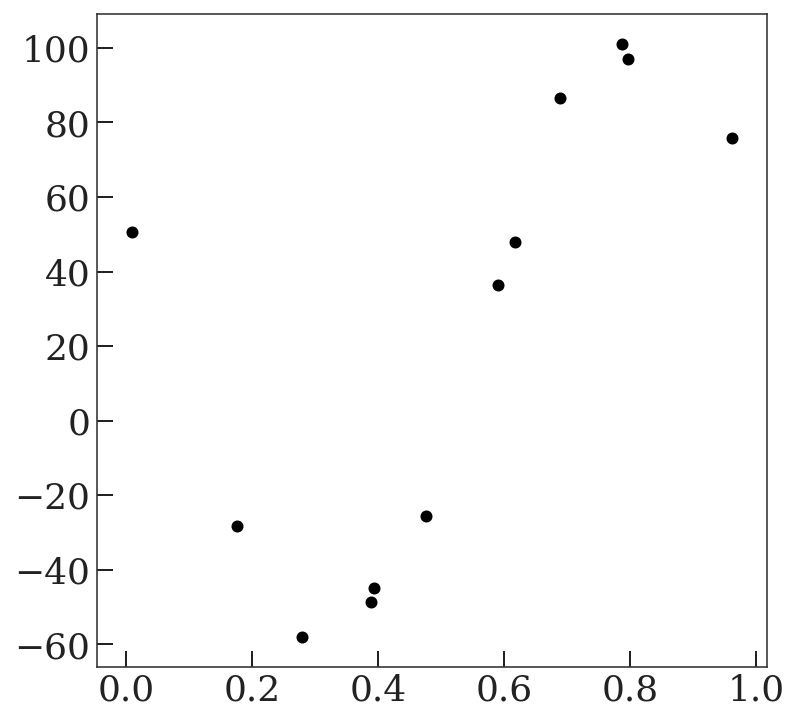

In [4]:
# plt.scatter((visits['JD'] / 0.9631649255752563) % 1., visits['VHELIO'])
# plt.scatter((row['JD'] / 0.9631649255752563) % 1., row['VHELIO'], color='tab:red')
plt.scatter((visits_tbl['JD'] / P) % 1, visits_tbl['VHELIO'])

In [5]:
visits = []
for row in visits_tbl:
    visit = Visit(row)
    frames = visit.frame_hdulists
    if frames is not None:
        visits.append(visit)
len(visits)

10

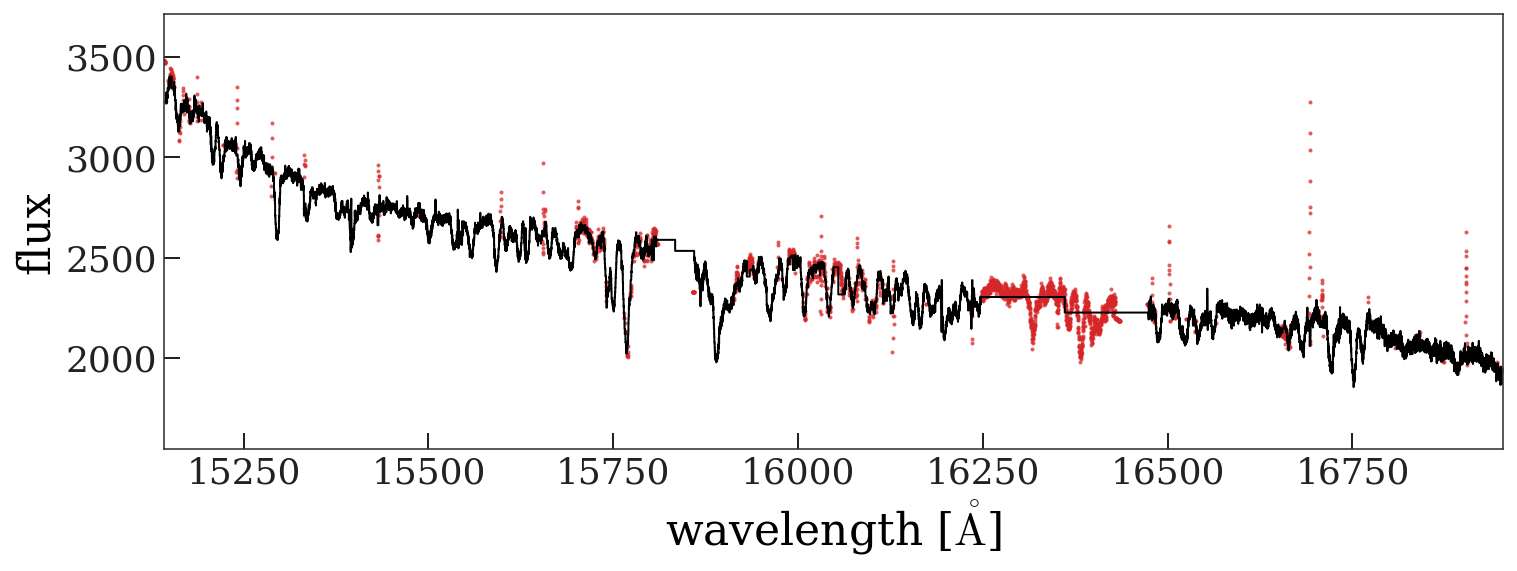

In [6]:
for visit in visits:
    fig = plot_spectrum_masked(visit.get_spectrum())
    break

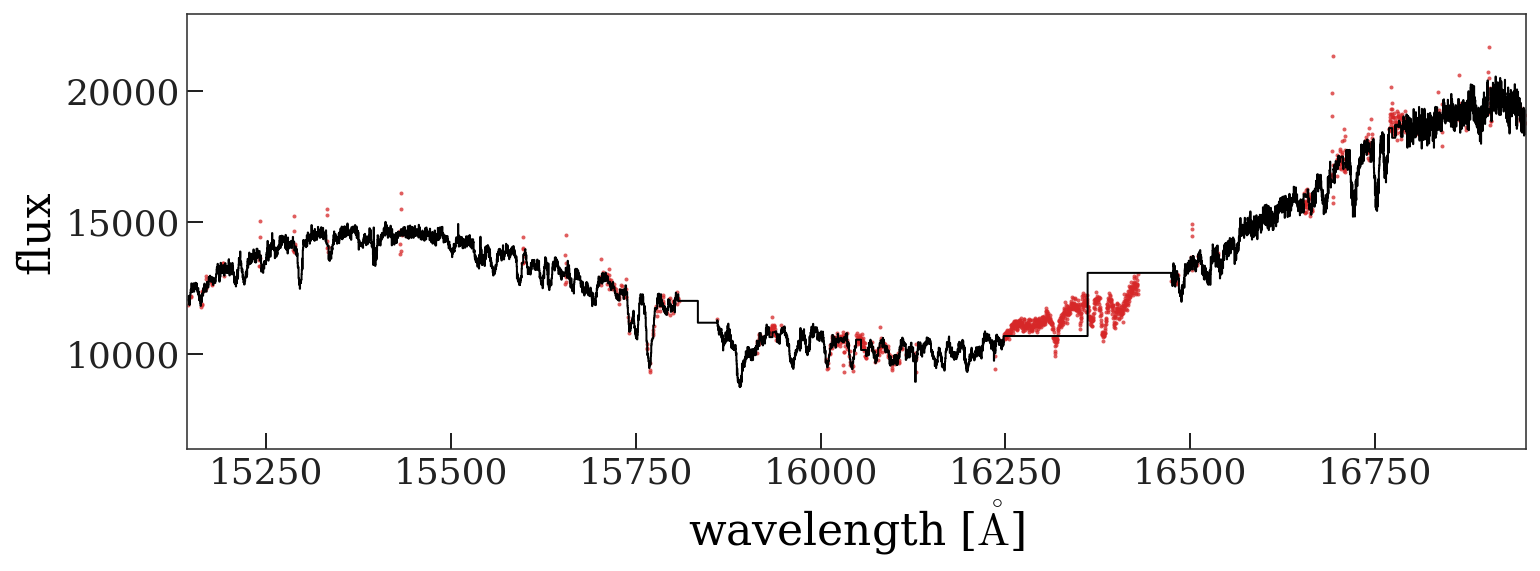

In [7]:
for visit in visits:
    # frame_spectra = visit.get_frame_spectra(percentile_clip=False)
    frame_spectra = visit.get_frame_spectra()
    for k, s in frame_spectra.items():
        fig = plot_spectrum_masked(s)
        break
    break

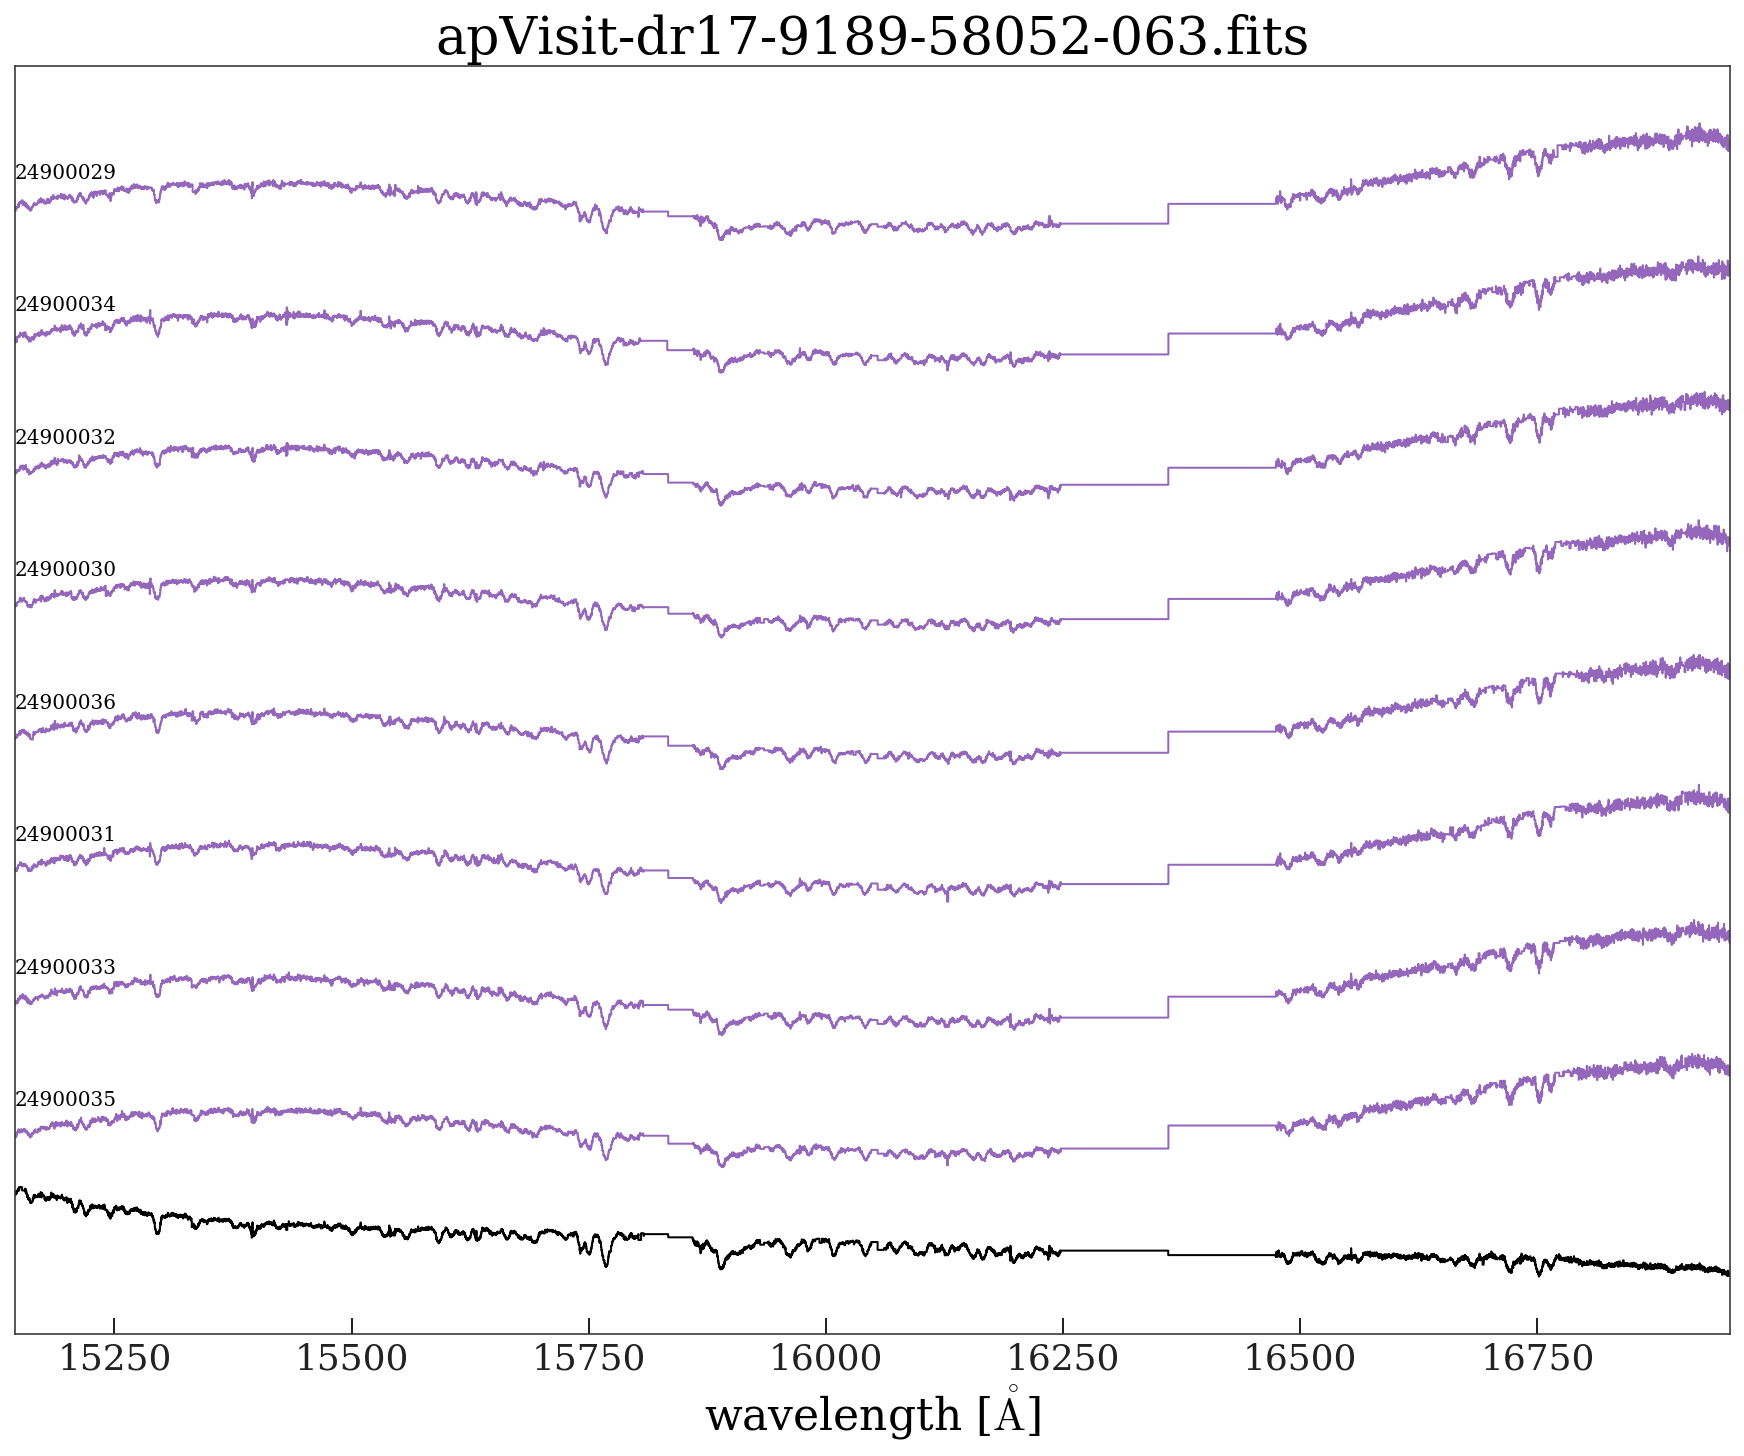

In [8]:
for visit in visits:
    fig, filename = plot_visit_frames(visit)
    fig.set_facecolor('w')

    filename.parent.mkdir(exist_ok=True, parents=True)
    fig.savefig(filename, dpi=250)
    break

- Audit masking
- Always make CC plots

In [11]:
normed_ref_spectrum.shape, s.shape

((8776,), (4388,))

In [9]:
mjds = []
cc_rvs = []
visit_vrels = []
rv_corrections = []
visit_pmf = []

np.random.seed(42)

for visit in sorted(visits, key=lambda x: x['JD']):
    spectra = visit.get_frame_spectra()
    
    other_visits = [v for v in visits if v['FILE'] != visit['FILE']]
    
    for frame, s in spectra.items():
        print(frame)
        
        time = visit.frame_times[frame]
        # 1) biased, but original choice:
        # visit_spectrum = visit.get_spectrum()
        
        # 2) works, but arbitrary
        other_visit = other_visits[1]  # or could pick randomly...
        visit_spectrum = other_visit.get_spectrum()
#         visit_spectrum_flux = shift_and_interpolate(visit_spectrum, 
#                                                     -(other_visit['VREL'] - visit['VREL'])*u.km/u.s,
#                                                     visit_spectrum.wavelength)
#         visit_spectrum = Spectrum1D(visit_spectrum_flux*u.one, 
#                                     spectral_axis=visit_spectrum.wavelength)

        # 3) use the leave-one-out combined spectrum
#         normed_ref_spectrum = normalize_ref_to_frame(
#             s, visit_spectrum, deg=9)  # MAGIC NUMBER
        
        # Apply the masks:
        visit_spectrum = apply_masks(visit_spectrum)
        s = apply_masks(s)
        
        normed_ref_spectrum = normalize_ref_to_frame(
            s, visit_spectrum, deg=9)  # MAGIC NUMBER
        
        normed_ref_spectrum, s = apply_masks(normed_ref_spectrum, s)
        
        fig, filename = plot_normalized_ref_spectrum(
            visit, frame,
            s, visit_spectrum, normed_ref_spectrum)
        filename.parent.mkdir(exist_ok=True, parents=True)
        fig.savefig(filename, dpi=250)
        plt.close(fig)
        
        dv = 4.*u.km/u.s
        cc, cc_vs = bag_of_hacks_cross_correlate(
#         cc, vs = cross_correlate(
            s, normed_ref_spectrum, 
            K_half=7, dv=dv)
        cc_dv, cc_poly = parabola_optimum(cc_vs.value, cc)
        
        cc_rvs.append(cc_dv)
        visit_vrels.append(visit['VREL'])
#         visit_vrels.append(other_visit['VREL'])
        mjds.append(time.tcb.mjd)
        
        rv_correct = visit.skycoord.radial_velocity_correction(
            obstime=time, location=visit.earth_location).to_value(u.km/u.s)
        rv_corrections.append(rv_correct)
        
        visit_pmf.append((int(visit['PLATE']), 
                          int(visit['FIBERID']), 
                          int(visit['FIBERID'])))

        # ---
#         fig, axes = plt.subplots(1, 2, figsize=(10, 5), 
#                                  sharex=True)

#         ax = axes[0]
#         ax.errorbar(vs.value, kernel, np.sqrt(np.diag(kernel_cov)),
#                     marker='o', ls='none')

#         ax.axhline(0, zorder=-10, color='#aaaaaa')
#         ax.axhline(1, zorder=-10, color='#aaaaaa')
#         ax.axvline(kern_dv, color='tab:green')
#         ax.set_title(frame)

#         ax = axes[1]
#         # ax.scatter(vs.value, (cc - 1) / 1e-3, color='#aaaaaa')
#         grid = np.linspace(cc_vs.value.min(), cc_vs.value.max(), 128)
#         # ax.plot(grid, (cc_poly(grid) - 1) / 1e-3, marker='')
#         ax.plot(grid, cc_poly(grid), marker='')
#         ax.scatter(cc_vs.value, cc, color='#aaaaaa')
#         ax.axvline(cc_dv, color='tab:green')
#         #ax.set_ylim(0.999, 1.001)
#         fig.tight_layout()
        break
    break
        
mjds = np.array(mjds)
cc_rvs = np.array(cc_rvs)
kernel_rvs = np.array(kernel_rvs)
visit_vrels = np.array(visit_vrels)
rv_corrections = np.array(rv_corrections)
visit_pmf = np.array(visit_pmf)

24560031


ValueError: Spectral axis length (1) must be the same size or one greater (if specifying bin edges) than that of the last flux axis (8776)

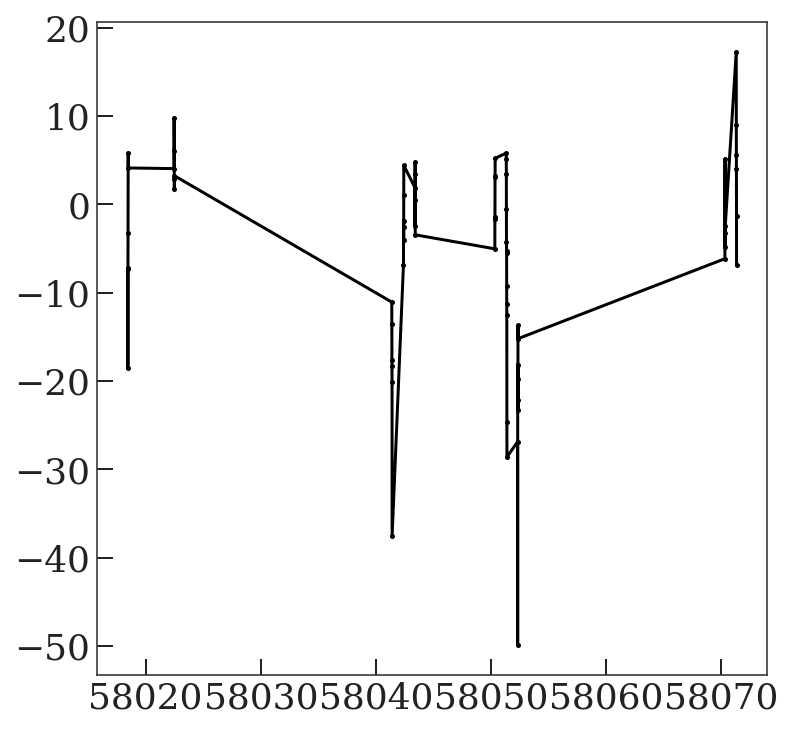

In [20]:
plt.plot(mjds[mjds.argsort()], cc_rvs[mjds.argsort()], marker='.', ls='-')

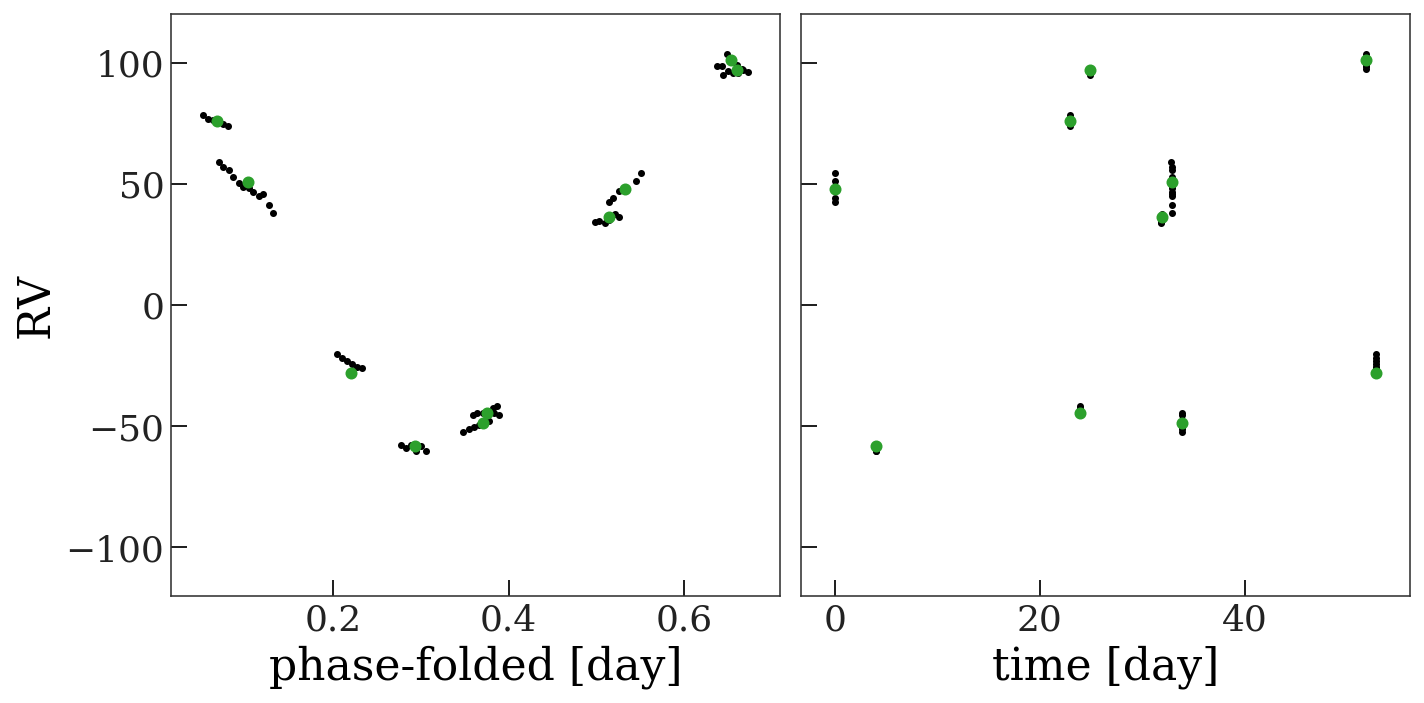

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

ax = axes[0]
ax.scatter(mjds % P, rv_corrections + cc_rvs + visit_vrels, marker='.')
# plt.scatter((mjds / P) % 1, rv_corrections + kernel_rvs + visit_vrels, marker='.')
ax.set_ylim(-120, 120)

ax.scatter(Time([v['JD'] for v in visits], format='jd').mjd % P, 
           [v['VHELIO'] for v in visits], 
           color='tab:green')

ax.set_xlabel('phase-folded [day]')
ax.set_ylabel('RV')

ax = axes[1]
ax.scatter(mjds - mjds.min(), rv_corrections + cc_rvs + visit_vrels, marker='.')
ax.scatter(Time([v['JD'] for v in visits], format='jd').mjd - mjds.min(), 
           [v['VHELIO'] for v in visits], 
           color='tab:green')
ax.set_xlabel('time [day]')

fig.set_facecolor('w')
fig.tight_layout()

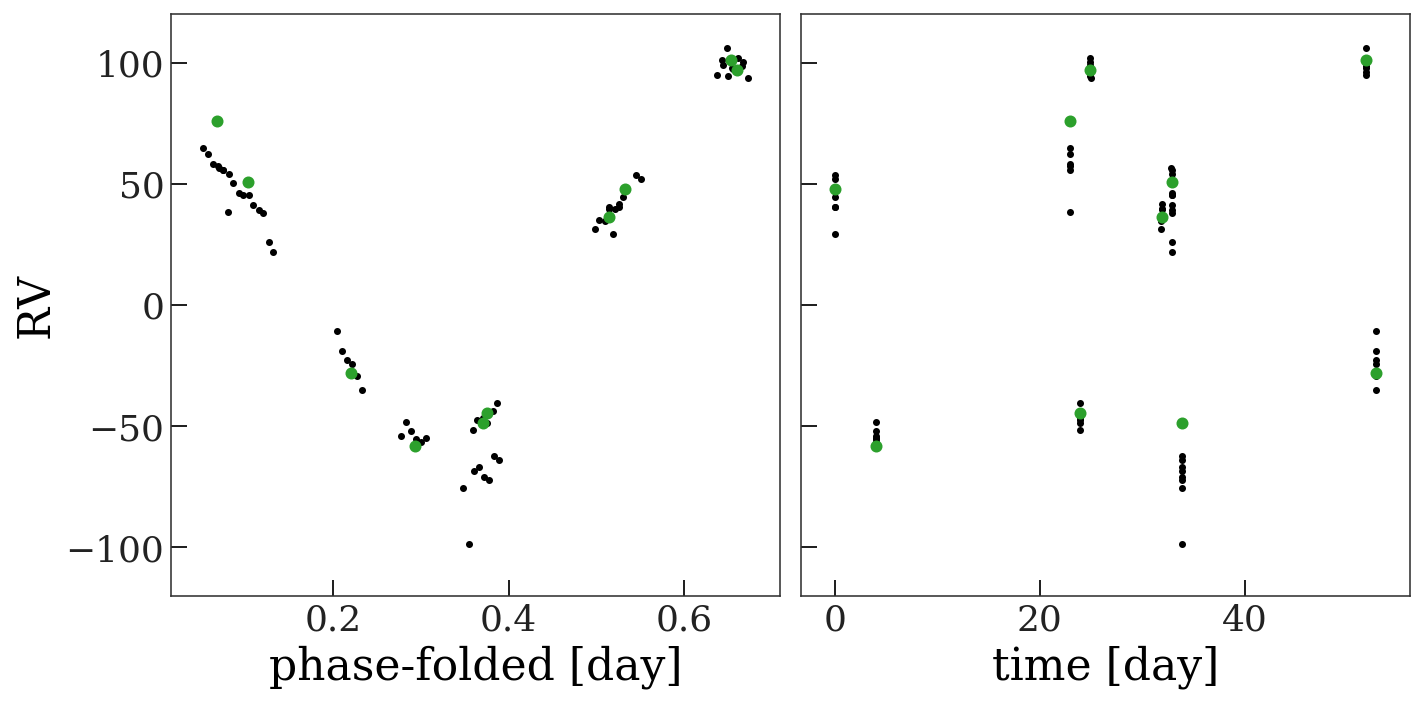

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

ax = axes[0]
ax.scatter(mjds % P, rv_corrections + cc_rvs + visit_vrels, marker='.')
# plt.scatter((mjds / P) % 1, rv_corrections + kernel_rvs + visit_vrels, marker='.')
ax.set_ylim(-120, 120)

ax.scatter(Time([v['JD'] for v in visits], format='jd').mjd % P, 
           [v['VHELIO'] for v in visits], 
           color='tab:green')

ax.set_xlabel('phase-folded [day]')
ax.set_ylabel('RV')

ax = axes[1]
ax.scatter(mjds - mjds.min(), rv_corrections + cc_rvs + visit_vrels, marker='.')
ax.scatter(Time([v['JD'] for v in visits], format='jd').mjd - mjds.min(), 
           [v['VHELIO'] for v in visits], 
           color='tab:green')
ax.set_xlabel('time [day]')

fig.set_facecolor('w')
fig.tight_layout()

Figure: APOGEE visit data with Joker samples

Figure: APOGEE visit data greyed out background, with Joker samples run on this data

TODO: formal error bars

TODO: find high SNR, high NVISITS stars in logg range: 3.2–3.8 (see Sam's chat)

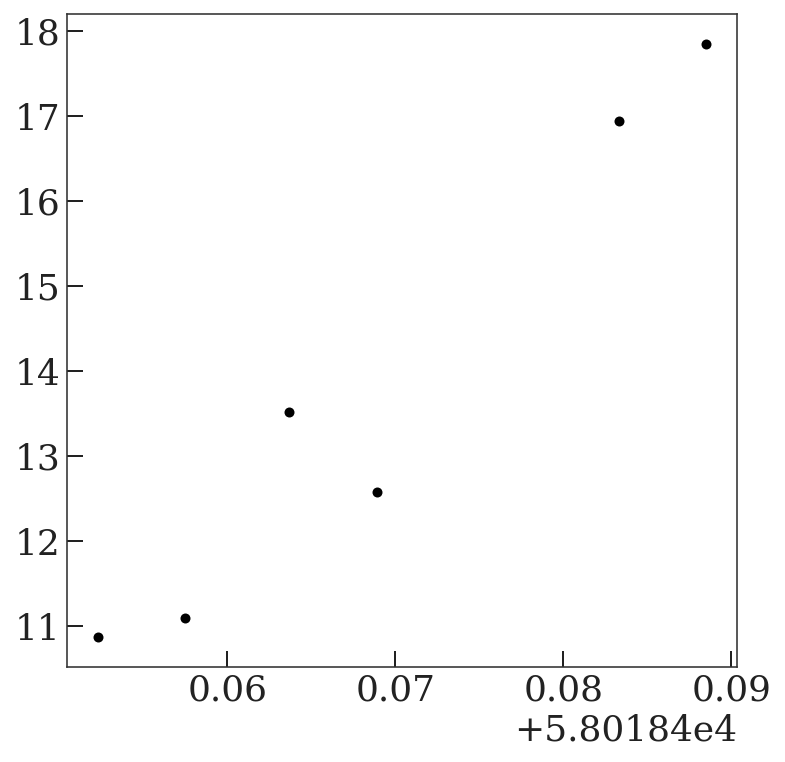

In [79]:
nights = mjds.astype(int)
for n in np.unique(nights):
    plt.figure()
    plt.plot(mjds[nights == n], (rv_corrections + cc_rvs)[nights == n],
             marker='o', ls='none')

(370, 375)

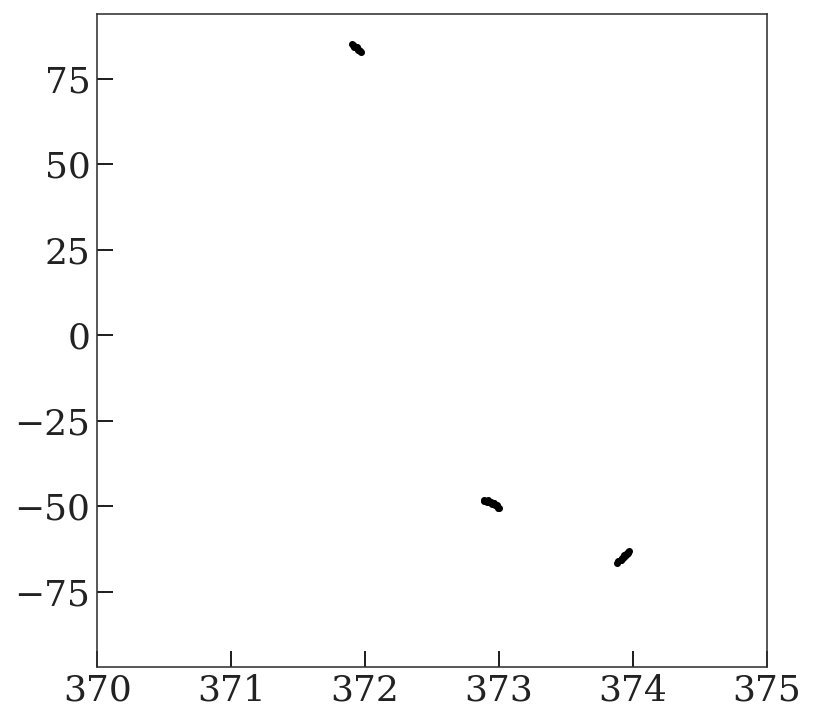

In [116]:
# plt.scatter(mjds, rv_corrections + cc_rvs + visit_vrels, marker='.')
plt.scatter(mjds - mjds.min(), rv_corrections - cc_rvs + visit_vrels, marker='.')
plt.xlim(370, 375)

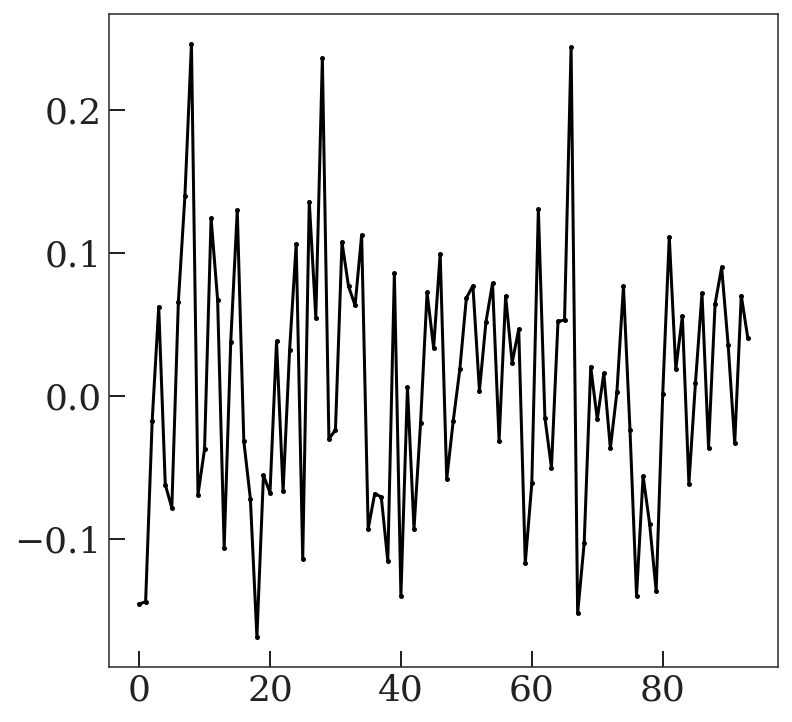

In [103]:
# plt.scatter(mjds, rv_corrections + cc_rvs + visit_vrels, marker='.')
# plt.scatter(mjds, rv_corrections - cc_rvs + visit_vrels, marker='.')

# plt.scatter((mjds / 2.8753170) % 1, rv_corrections - cc_rvs + visit_vrels, marker='.')
# plt.scatter(mjds, cc_rvs, marker='.')
plt.plot(cc_rvs[mjds.argsort()], marker='.', ls='-')

# plt.scatter(mjds, rv_corrections)

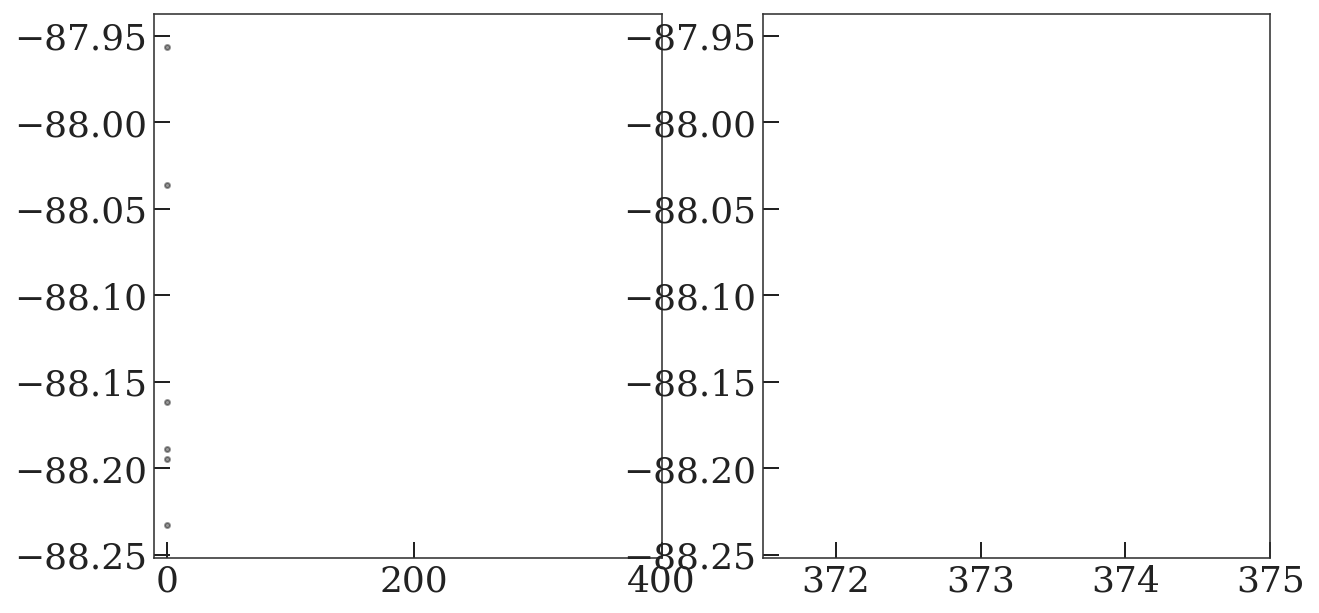

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
ax.scatter(mjds - min(mjds), visit_rvs - cc_rvs, 
           marker='.', alpha=0.4)
# ax.set_ylim(-20, 70)
ax.set_xlim(-10, 400)

ax = axes[1]
ax.scatter(mjds - min(mjds), visit_rvs - cc_rvs, 
           marker='.', alpha=0.4)
# ax.set_xlim(-0.2, 1.2)
ax.set_xlim(371.5, 375)
    
fig.set_facecolor('w')

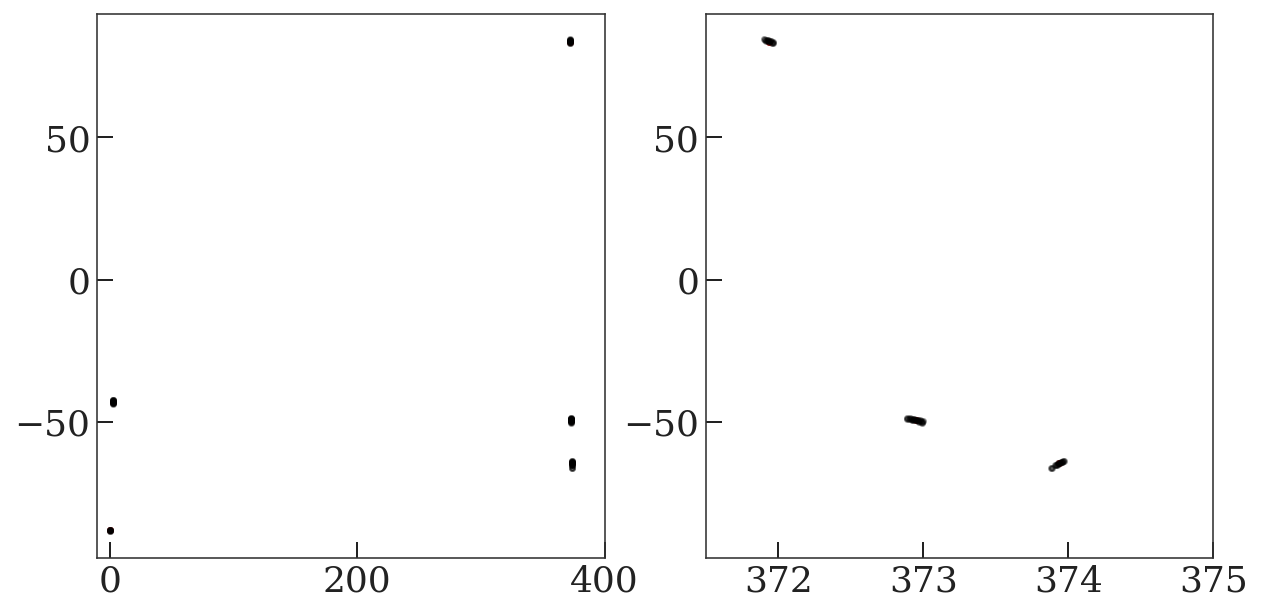

In [102]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
ax.scatter(mjds - min(mjds), visit_rvs - cc_rvs, 
           marker='.', alpha=0.4)
# ax.set_ylim(-20, 70)
ax.set_xlim(-10, 400)

ax = axes[1]
ax.scatter(mjds - min(mjds), visit_rvs - cc_rvs, 
           marker='.', alpha=0.4)
# ax.set_xlim(-0.2, 1.2)
ax.set_xlim(371.5, 375)

for ax in axes:
    ax.scatter(Time(visits_tbl['JD'], format='jd').mjd - min(mjds),
               visits_tbl['VHELIO'],
               marker='.', color='tab:red', zorder=-100)
    
fig.set_facecolor('w')

(-20, 70)

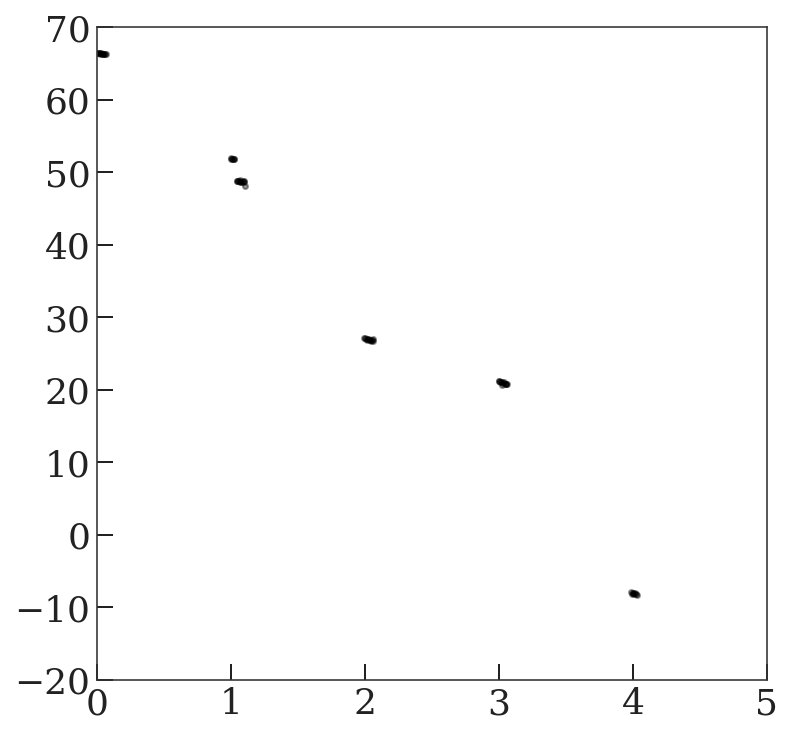

In [50]:
plt.scatter(mjds - min(mjds), kernel_rvs + visit_rvs, marker='.', alpha=0.4)
plt.xlim(0, 5)
plt.ylim(-20, 70)

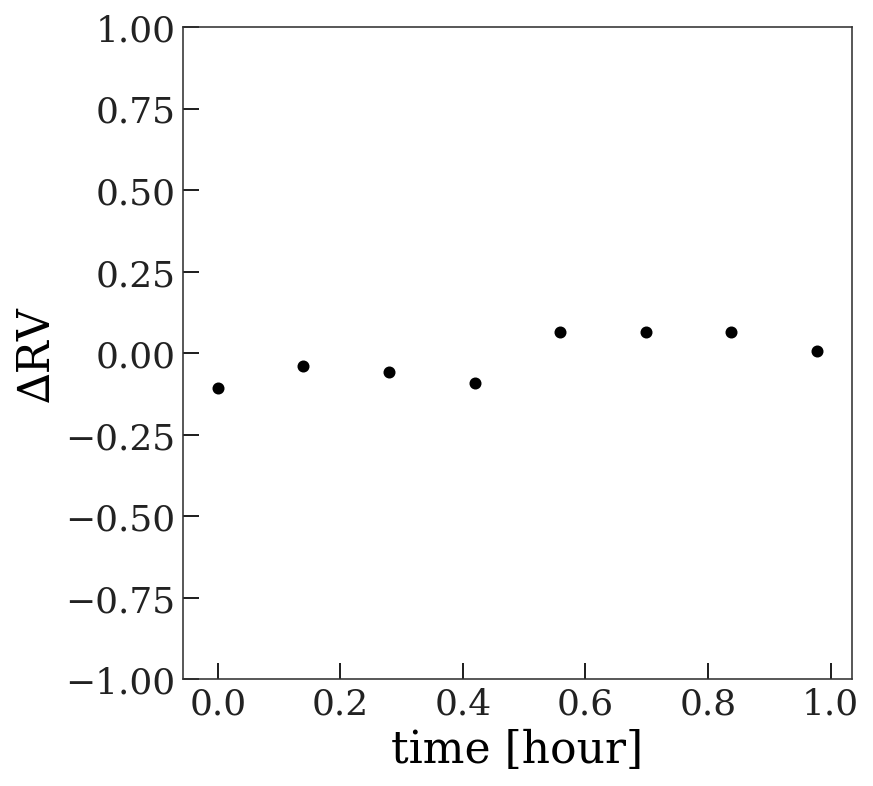

In [79]:
# plt.scatter(np.array(mjds) - min(mjds), visit['VHELIO'] - np.array(dvs))
# plt.scatter(np.array(mjds) - min(mjds), visit['VHELIO'] - np.array(cc_dvs))
# plt.plot(np.array(mjds) - min(mjds), orbit.radial_velocity(Time(mjds, format='mjd')))

fig = plt.figure()
# plt.scatter((np.array(mjds) - min(mjds)) * 24, np.array(dvs))
plt.scatter((np.array(mjds) - min(mjds)) * 24, np.array(cc_dvs))
plt.xlabel('time [hour]')
plt.ylabel('∆RV')
# plt.ylim(-5, 5)
plt.ylim(-1, 1)
fig.set_facecolor('w')

### TODO

- Multiple visits
- Plot visit velocities and frame velocities
- Compare stitching CC's and centroided velocities
- Improve the CC code to best practices (subtract the mean?)

In [24]:
from scipy.ndimage import gaussian_filter1d
from astropy.stats import sigma_clip

In [117]:
smooth = 100  # MAGIC

In [184]:
visit = visits[0]
spectra = visit.load_frame_spectra()

for frame, s in spectra.items():
    print(frame)

    time = visit.frame_times[frame]

    normed_ref_spectrum = normalize_ref_to_frame(
        s, visit.spectrum, deg=7)
    
    break

22950020


In [219]:
# f = normed_ref_spectrum.flux.copy()
# clipped_local = sigma_clip(f - 0.5*np.roll(f, 1) - 0.5*np.roll(f, -1), 
#                            sigma=5, maxiters=10)

# fuck = f - 0.5*np.roll(f, 1) - 0.5*np.roll(f, -1)

# plt.figure()
# plt.plot(normed_ref_spectrum.wavelength, fuck)
# plt.plot(normed_ref_spectrum.wavelength[clipped_local.mask], 
#          fuck[clipped_local.mask], color='r', ls='none', marker='.')

# plt.figure()
# plt.plot(normed_ref_spectrum.wavelength, normed_ref_spectrum.flux)
# plt.plot(normed_ref_spectrum.wavelength[clipped_local.mask], 
#          normed_ref_spectrum.flux[clipped_local.mask], 
#          color='r', ls='none', marker='.')

# normed_ref_spectrum = Spectrum1D(
#     f[~clipped_local.mask],
#     spectral_axis=normed_ref_spectrum.wavelength[~clipped_local.mask]
# )

In [186]:
# smooth_frame_flux = gaussian_filter1d(s.flux, sigma=smooth)
# frame_flux_diff = s.flux - smooth_frame_flux
# frame_flux_diff /= np.linalg.norm(frame_flux_diff)
# # plt.plot(frame_flux_diff)

In [187]:
# from subframe.velocity import shift_and_interpolate
# frame_spectrum = s

# shifted_flux = shift_and_interpolate(normed_ref_spectrum,
#                                      0,
#                                      frame_spectrum.wavelength)

# smooth_ref_flux = gaussian_filter1d(shifted_flux, sigma=smooth)
# ref_flux_diff = shifted_flux - smooth_ref_flux
# ref_flux_diff /= np.linalg.norm(ref_flux_diff)

# clipped = sigma_clip(frame_flux_diff - ref_flux_diff, sigma=3)
# clip_mask = clipped.mask.copy()
# for shift in np.arange(-1, 1+1):
#     clip_mask |= np.roll(clip_mask, shift=shift)
# clip_mask[0] = clip_mask[-1] = 1

# print(clip_mask.sum())
# clipped_local = sigma_clip(frame_flux_diff - 0.5*np.roll(frame_flux_diff, 1) - 0.5*np.roll(frame_flux_diff, -1), 
#                            sigma=5)
# clip_mask |= clipped_local.mask
# print(clip_mask.sum())

488
489


In [188]:
# tmp = Spectrum1D(
#     shifted_flux[~clipped.mask] * u.one,
#     spectral_axis=frame_spectrum.wavelength[~clipped.mask])

In [189]:
dv = 8*u.km/u.s
vs = np.arange(-1, 1+1) * dv
terms = []
for v in vs:
    shifted_flux = shift_and_interpolate(normed_ref_spectrum,
                                         v,
                                         frame_spectrum.wavelength[~clip_mask])
    
    smooth_ref_flux = gaussian_filter1d(shifted_flux, sigma=smooth)
    ref_flux_diff = shifted_flux - smooth_ref_flux
    ref_flux_diff /= np.linalg.norm(ref_flux_diff)
    
    terms.append(ref_flux_diff)

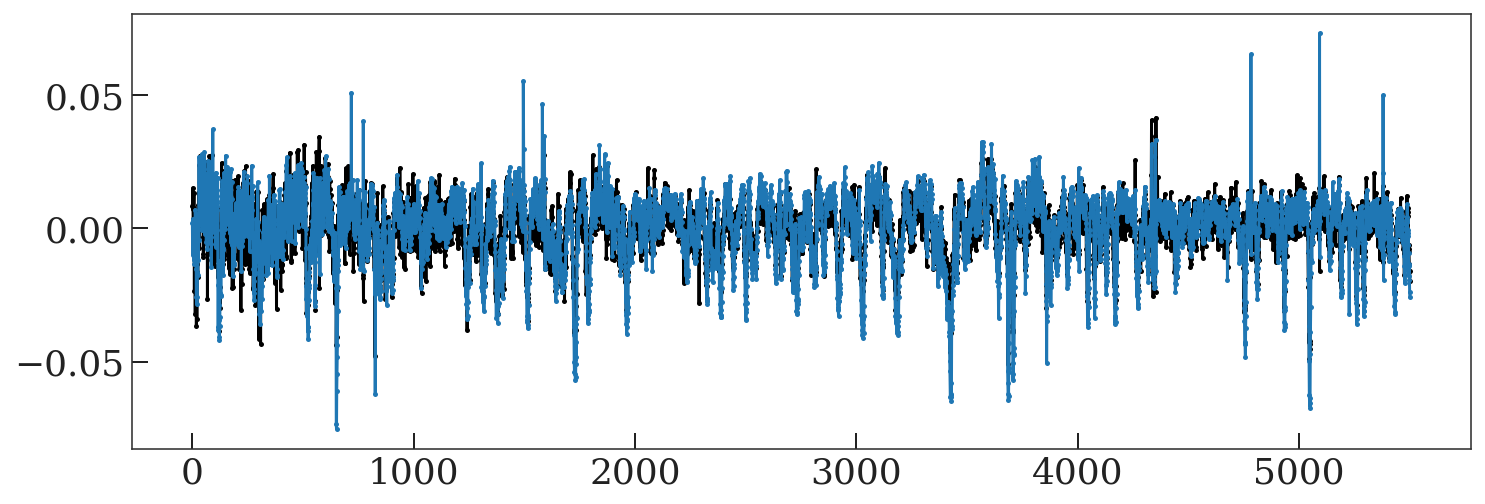

In [190]:
plt.figure(figsize=(12, 4))
plt.plot(frame_flux_diff[~clip_mask])
plt.plot(terms[0])

In [191]:
# M = np.stack(terms).T
# from subframe.utils import parabola_optimum

In [220]:
# Cinv = 1 / frame_spectrum.uncertainty.array**2

# # denom = np.sqrt(np.diag((M.T * Cinv) @ M) *
# #                 ((frame_spectrum.flux.T * Cinv) @ frame_spectrum.flux))
# # crosscorr = ((M.T * Cinv) @ frame_spectrum.flux) / denom

# cc = M.T @ frame_flux_diff[~clip_mask]

# cc_dv, _ = parabola_optimum(vs.value, cc)
# cc_dv

In [221]:
# cc, vs = cross_correlate(
#     s, normed_ref_spectrum, 
#     K_half=1)
# cc_dv_old, _ = parabola_optimum(vs.value, cc)
# cc_dv_old